In [ ]:
s!pip install river
!pip install openmeteo-requests
!pip install requests-cache retry-requests numpy pandas

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 39.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.2/41.2 MB 11.8 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.13.1
    Uninstalling scipy-1.13.1:
      Successfully uninstalled scipy-1.13.1
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.10.1 requires pandas<2.2.3dev0,>=2.0, but you have pandas 2.2.3 which is incompatible.
gensim 4.3.3 requires scipy

In [ ]:
import pandas as pd
from pandas.plotting import autocorrelation_plot
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import skew, kurtosis
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.feature_selection import mutual_info_regression

import river
from river import linear_model, metrics, preprocessing, time_series, compose, evaluate
from river import optim

import openmeteo_requests
import requests_cache
from retry_requests import retry

pd.set_option('display.max_columns', 100)

# Data loading

In [ ]:
# Load the dataset
file_path = '/content/drive/MyDrive/TFM/data_SM1.csv'
data = pd.read_csv(file_path)

# Convert the 'temps' column to datetime format
data['temps'] = pd.to_datetime(data['temps'])

# Set the 'temps' column as the index
data.set_index('temps', inplace=True)

# Display the first 5 rows of the dataset
data.head()

,separador-10_SM1_separador-13_SM2_modvalv,T4_CoolingP,T4_ElectricP,T3_CoolingP,T3_ElectricP,T2_CoolingP,T2_ElectricP,T1_CoolingP,T1_ElectricP,Suction_P_separador-10_SM1,Discharge_P,utc,T4_CoolingL,T3_CoolingL,T2_CoolingL,T1_CoolingL
temps,,,,,,,,,,,,,,,,
2023-02-27 00:00:00,0.4,0.0,0.0,0.0,0.0,567.870056,170.999924,0.0,1.0,1.997,9.961,2023-02-26 23:00:00+00:00,NaN,NaN,NaN,NaN
2023-02-27 00:01:00,0.4,0.0,0.0,0.0,0.0,573.448303,171.999924,0.0,1.0,2.007,9.899,2023-02-26 23:01:00+00:00,NaN,NaN,NaN,NaN
2023-02-27 00:02:00,0.4,0.0,0.0,0.0,0.0,574.060120,173.999924,0.0,1.0,2.023,10.008,2023-02-26 23:02:00+00:00,NaN,NaN,NaN,NaN
2023-02-27 00:03:00,0.4,0.0,0.0,0.0,0.0,575.971985,173.999924,0.0,1.0,1.999,10.116,2023-02-26 23:03:00+00:00,NaN,NaN,NaN,NaN
2023-02-27 00:04:00,0.4,0.0,0.0,0.0,0.0,581.486511,175.999924,0.0,1.0,2.011,10.066,2023-02-26 23:04:00+00:00,NaN,NaN,NaN,NaN


In [ ]:
# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after = -1)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

# Make sure all required weather variables are listed here
# The order of variables in hourly or daily is important to assign them correctly below
url = "https://archive-api.open-meteo.com/v1/archive"
params = {
	"latitude": 41.7833,
	"longitude": 1.3,
	"start_date": "2023-02-27",
	"end_date": "2024-07-28",
	"hourly": ["temperature_2m", "relative_humidity_2m", "dew_point_2m", "apparent_temperature", "precipitation", "rain", "snowfall", "surface_pressure", "cloud_cover", "wind_speed_10m", "soil_temperature_0_to_7cm", "soil_temperature_7_to_28cm", "soil_temperature_28_to_100cm", "soil_moisture_0_to_7cm", "soil_moisture_7_to_28cm", "soil_moisture_28_to_100cm"],
	"wind_speed_unit": "ms",
	"timezone": "auto"
}
responses = openmeteo.weather_api(url, params=params)

# Process first location. Add a for-loop for multiple locations or weather models
response = responses[0]
print(f"Coordinates {response.Latitude()}°N {response.Longitude()}°E")
print(f"Elevation {response.Elevation()} m asl")
print(f"Timezone {response.Timezone()} {response.TimezoneAbbreviation()}")
print(f"Timezone difference to GMT+0 {response.UtcOffsetSeconds()} s")

# Process hourly data. The order of variables needs to be the same as requested.
hourly = response.Hourly()
hourly_temperature_2m = hourly.Variables(0).ValuesAsNumpy()
hourly_relative_humidity_2m = hourly.Variables(1).ValuesAsNumpy()
hourly_dew_point_2m = hourly.Variables(2).ValuesAsNumpy()
hourly_apparent_temperature = hourly.Variables(3).ValuesAsNumpy()
hourly_precipitation = hourly.Variables(4).ValuesAsNumpy()
hourly_rain = hourly.Variables(5).ValuesAsNumpy()
hourly_snowfall = hourly.Variables(6).ValuesAsNumpy()
hourly_surface_pressure = hourly.Variables(7).ValuesAsNumpy()
hourly_cloud_cover = hourly.Variables(8).ValuesAsNumpy()
hourly_wind_speed_10m = hourly.Variables(9).ValuesAsNumpy()
hourly_soil_temperature_0_to_7cm = hourly.Variables(10).ValuesAsNumpy()
hourly_soil_temperature_7_to_28cm = hourly.Variables(11).ValuesAsNumpy()
hourly_soil_temperature_28_to_100cm = hourly.Variables(12).ValuesAsNumpy()
hourly_soil_moisture_0_to_7cm = hourly.Variables(13).ValuesAsNumpy()
hourly_soil_moisture_7_to_28cm = hourly.Variables(14).ValuesAsNumpy()
hourly_soil_moisture_28_to_100cm = hourly.Variables(15).ValuesAsNumpy()

hourly_data = {"date": pd.date_range(
	start = pd.to_datetime(hourly.Time(), unit = "s", utc = True),
	end = pd.to_datetime(hourly.TimeEnd(), unit = "s", utc = True),
	freq = pd.Timedelta(seconds = hourly.Interval()),
	inclusive = "left"
)}
hourly_data["temperature_2m"] = hourly_temperature_2m
hourly_data["relative_humidity_2m"] = hourly_relative_humidity_2m
hourly_data["dew_point_2m"] = hourly_dew_point_2m
hourly_data["apparent_temperature"] = hourly_apparent_temperature
hourly_data["precipitation"] = hourly_precipitation
hourly_data["rain"] = hourly_rain
hourly_data["snowfall"] = hourly_snowfall
hourly_data["surface_pressure"] = hourly_surface_pressure
hourly_data["cloud_cover"] = hourly_cloud_cover
hourly_data["wind_speed_10m"] = hourly_wind_speed_10m
hourly_data["soil_temperature_0_to_7cm"] = hourly_soil_temperature_0_to_7cm
hourly_data["soil_temperature_7_to_28cm"] = hourly_soil_temperature_7_to_28cm
hourly_data["soil_temperature_28_to_100cm"] = hourly_soil_temperature_28_to_100cm
hourly_data["soil_moisture_0_to_7cm"] = hourly_soil_moisture_0_to_7cm
hourly_data["soil_moisture_7_to_28cm"] = hourly_soil_moisture_7_to_28cm
hourly_data["soil_moisture_28_to_100cm"] = hourly_soil_moisture_28_to_100cm

hourly_dataframe = pd.DataFrame(data = hourly_data)
hourly_dataframe.head()

Coordinates 41.79261779785156°N 1.3043477535247803°E
Elevation 513.0 m asl
Timezone b'Europe/Madrid' b'CET'
Timezone difference to GMT+0 3600 s


,date,temperature_2m,relative_humidity_2m,dew_point_2m,apparent_temperature,precipitation,rain,snowfall,surface_pressure,cloud_cover,wind_speed_10m,soil_temperature_0_to_7cm,soil_temperature_7_to_28cm,soil_temperature_28_to_100cm,soil_moisture_0_to_7cm,soil_moisture_7_to_28cm,soil_moisture_28_to_100cm
0,2023-02-26 23:00:00+00:00,1.0765,34.663998,-12.823500,-5.188007,0.0,0.0,0.0,945.678650,34.0,5.353504,4.0265,5.7765,5.5765,0.279,0.225,0.057
1,2023-02-27 00:00:00+00:00,1.6265,34.974651,-12.223500,-4.328067,0.0,0.0,0.0,945.234863,1.0,4.838388,5.1265,5.8265,5.5765,0.279,0.225,0.056
2,2023-02-27 01:00:00+00:00,1.1265,34.960670,-12.673500,-4.789116,0.0,0.0,0.0,945.220215,74.0,4.707441,4.3265,5.7265,5.6265,0.278,0.225,0.056
3,2023-02-27 02:00:00+00:00,0.4265,34.044380,-13.623500,-5.127682,0.0,0.0,0.0,945.442932,100.0,3.905125,3.5765,5.6265,5.6265,0.278,0.225,0.056
4,2023-02-27 03:00:00+00:00,0.8765,36.760948,-12.273499,-3.328840,0.0,0.0,0.0,945.728699,100.0,1.500000,3.3265,5.4765,5.6265,0.277,0.225,0.056


In [ ]:
# Ensure datetime columns are in datetime format
data.index = pd.to_datetime(data.index)
hourly_dataframe['date'] = pd.to_datetime(hourly_dataframe['date'])

# Convert both datetime columns to the same timezone (UTC)
data.index = data.index.tz_localize('UTC') if data.index.tz is None else data.index.tz_convert('UTC')
hourly_dataframe['date'] = (
    hourly_dataframe['date'].dt.tz_localize('UTC') if hourly_dataframe['date'].dt.tz is None
    else hourly_dataframe['date'].dt.tz_convert('UTC')
)

# Expand weather data to minute-level resolution
weather_data = hourly_dataframe.set_index('date')
weather_data_expanded = weather_data.resample('min').ffill().reset_index()

# Merge data (using index as datetime) with expanded weather data
data.reset_index(inplace=True)  # Reset index to bring 'temps' back as a column
data = pd.merge_asof(
    data.sort_values('temps'),
    weather_data_expanded.sort_values('date'),
    left_on='temps',
    right_on='date',
    direction='backward'
)

# Resulting DataFrame
data.head()

,temps,separador-10_SM1_separador-13_SM2_modvalv,T4_CoolingP,T4_ElectricP,T3_CoolingP,T3_ElectricP,T2_CoolingP,T2_ElectricP,T1_CoolingP,T1_ElectricP,Suction_P_separador-10_SM1,Discharge_P,utc,T4_CoolingL,T3_CoolingL,T2_CoolingL,T1_CoolingL,date,temperature_2m,relative_humidity_2m,dew_point_2m,apparent_temperature,precipitation,rain,snowfall,surface_pressure,cloud_cover,wind_speed_10m,soil_temperature_0_to_7cm,soil_temperature_7_to_28cm,soil_temperature_28_to_100cm,soil_moisture_0_to_7cm,soil_moisture_7_to_28cm,soil_moisture_28_to_100cm
0,2023-02-27 00:00:00+00:00,0.4,0.0,0.0,0.0,0.0,567.870056,170.999924,0.0,1.0,1.997,9.961,2023-02-26 23:00:00+00:00,NaN,NaN,NaN,NaN,2023-02-27 00:00:00+00:00,1.6265,34.974651,-12.2235,-4.328067,0.0,0.0,0.0,945.234863,1.0,4.838388,5.1265,5.8265,5.5765,0.279,0.225,0.056
1,2023-02-27 00:01:00+00:00,0.4,0.0,0.0,0.0,0.0,573.448303,171.999924,0.0,1.0,2.007,9.899,2023-02-26 23:01:00+00:00,NaN,NaN,NaN,NaN,2023-02-27 00:01:00+00:00,1.6265,34.974651,-12.2235,-4.328067,0.0,0.0,0.0,945.234863,1.0,4.838388,5.1265,5.8265,5.5765,0.279,0.225,0.056
2,2023-02-27 00:02:00+00:00,0.4,0.0,0.0,0.0,0.0,574.060120,173.999924,0.0,1.0,2.023,10.008,2023-02-26 23:02:00+00:00,NaN,NaN,NaN,NaN,2023-02-27 00:02:00+00:00,1.6265,34.974651,-12.2235,-4.328067,0.0,0.0,0.0,945.234863,1.0,4.838388,5.1265,5.8265,5.5765,0.279,0.225,0.056
3,2023-02-27 00:03:00+00:00,0.4,0.0,0.0,0.0,0.0,575.971985,173.999924,0.0,1.0,1.999,10.116,2023-02-26 23:03:00+00:00,NaN,NaN,NaN,NaN,2023-02-27 00:03:00+00:00,1.6265,34.974651,-12.2235,-4.328067,0.0,0.0,0.0,945.234863,1.0,4.838388,5.1265,5.8265,5.5765,0.279,0.225,0.056
4,2023-02-27 00:04:00+00:00,0.4,0.0,0.0,0.0,0.0,581.486511,175.999924,0.0,1.0,2.011,10.066,2023-02-26 23:04:00+00:00,NaN,NaN,NaN,NaN,2023-02-27 00:04:00+00:00,1.6265,34.974651,-12.2235,-4.328067,0.0,0.0,0.0,945.234863,1.0,4.838388,5.1265,5.8265,5.5765,0.279,0.225,0.056


# Initial EDA


In [ ]:
data.shape

(745860, 34)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 745860 entries, 0 to 745859
Data columns (total 34 columns):
 #   Column                                     Non-Null Count   Dtype              
---  ------                                     --------------   -----              
 0   temps                                      745860 non-null  datetime64[ns, UTC]
 1   separador-10_SM1_separador-13_SM2_modvalv  745234 non-null  float64            
 2   T4_CoolingP                                745511 non-null  float64            
 3   T4_ElectricP                               745511 non-null  float64            
 4   T3_CoolingP                                745512 non-null  float64            
 5   T3_ElectricP                               745512 non-null  float64            
 6   T2_CoolingP                                745514 non-null  float64            
 7   T2_ElectricP                               745514 non-null  float64            
 8   T1_CoolingP                       

# Data quality assesment

In [ ]:
data.isnull().sum()

,0
temps,0
separador-10_SM1_separador-13_SM2_modvalv,626
T4_CoolingP,349
T4_ElectricP,349
T3_CoolingP,348
T3_ElectricP,348
T2_CoolingP,346
T2_ElectricP,346
T1_CoolingP,348
T1_ElectricP,348


In [ ]:
data.describe()

,separador-10_SM1_separador-13_SM2_modvalv,T4_CoolingP,T4_ElectricP,T3_CoolingP,T3_ElectricP,T2_CoolingP,T2_ElectricP,T1_CoolingP,T1_ElectricP,Suction_P_separador-10_SM1,Discharge_P,T4_CoolingL,T3_CoolingL,T2_CoolingL,T1_CoolingL,temperature_2m,relative_humidity_2m,dew_point_2m,apparent_temperature,precipitation,rain,snowfall,surface_pressure,cloud_cover,wind_speed_10m,soil_temperature_0_to_7cm,soil_temperature_7_to_28cm,soil_temperature_28_to_100cm,soil_moisture_0_to_7cm,soil_moisture_7_to_28cm,soil_moisture_28_to_100cm
count,745234.000000,745511.000000,745511.000000,745512.000000,745512.000000,745514.000000,745514.000000,745512.000000,745512.000000,745598.000000,745234.000000,90702.000000,90702.000000,90702.000000,90702.000000,745860.000000,745860.000000,745860.000000,745860.000000,745860.000000,745860.000000,745860.000000,745860.000000,745860.000000,745860.000000,745860.000000,745860.000000,745860.000000,745860.000000,745860.000000,745860.000000
mean,21.813977,772.363002,196.803169,252.467662,76.118152,129.916429,40.740756,132.875321,33.785142,2.002538,9.808154,36.312861,41.675117,10.451811,21.644555,15.826954,63.654545,7.688540,14.169230,0.057831,0.057662,0.000118,956.733765,47.312847,2.862497,17.109669,16.848665,16.105289,0.207469,0.182524,0.077318
std,38.617592,719.855777,178.686538,506.243931,144.995927,275.159106,79.498718,361.796611,82.217201,0.149889,0.680958,33.070508,45.666855,20.944987,34.168993,8.255041,22.494930,5.930502,9.304585,0.413402,0.412227,0.007965,6.738178,41.526676,1.736835,9.009122,7.767357,5.981939,0.061351,0.034264,0.066093
min,-0.100000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,0.000000,0.000000,-0.100000,-0.100000,0.000000,-4.173500,5.522460,-21.323502,-8.733866,0.000000,0.000000,0.000000,926.081360,0.000000,0.000000,-3.423500,0.276500,5.526500,0.117000,0.137000,0.000000
25%,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.968000,9.860000,0.600000,-0.100000,2.500000,0.000000,9.326500,45.399048,3.576500,6.754519,0.000000,0.000000,0.000000,953.997009,3.000000,1.565248,10.176500,10.576500,11.076500,0.155000,0.153000,0.020000
50%,0.500000,832.113892,220.999908,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2.001000,9.972000,39.300000,0.000000,4.400000,1.900000,15.626500,65.379562,7.626500,13.761913,0.000000,0.000000,0.000000,957.019714,38.000000,2.549510,17.226500,16.876499,15.826500,0.197000,0.172000,0.031000
75%,26.200000,1402.437622,350.999847,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2.037000,10.048000,61.400000,93.800000,7.800000,17.500000,21.726500,83.314301,12.226501,21.152069,0.000000,0.000000,0.000000,960.056946,97.000000,3.801316,23.726500,23.026499,21.776499,0.248000,0.200000,0.151000
max,99.800000,2652.490234,568.999756,2505.831787,499.999786,1774.123413,499.999786,2654.827881,499.999786,5.512000,13.780000,100.000000,100.900000,100.000000,100.000000,40.076500,100.000000,21.576500,40.558922,10.900000,10.900000,0.770000,977.184021,100.000000,12.269067,41.576500,33.426498,27.076500,0.434000,0.293000,0.160000


In [ ]:
# Check for duplicate values in the index variable 'temps'

# Identify the duplicated index values
duplicated_indices = data.index[data.index.duplicated(keep=False)]

# Filter the DataFrame to show only the rows with duplicate indices
duplicates_df = data.loc[duplicated_indices]

# Display the filtered DataFrame with duplicates
duplicates_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 0 entries
Data columns (total 34 columns):
 #   Column                                     Non-Null Count  Dtype              
---  ------                                     --------------  -----              
 0   temps                                      0 non-null      datetime64[ns, UTC]
 1   separador-10_SM1_separador-13_SM2_modvalv  0 non-null      float64            
 2   T4_CoolingP                                0 non-null      float64            
 3   T4_ElectricP                               0 non-null      float64            
 4   T3_CoolingP                                0 non-null      float64            
 5   T3_ElectricP                               0 non-null      float64            
 6   T2_CoolingP                                0 non-null      float64            
 7   T2_ElectricP                               0 non-null      float64            
 8   T1_CoolingP                                0 non-null      float64 

# Statistical Profile and Variable Distribution

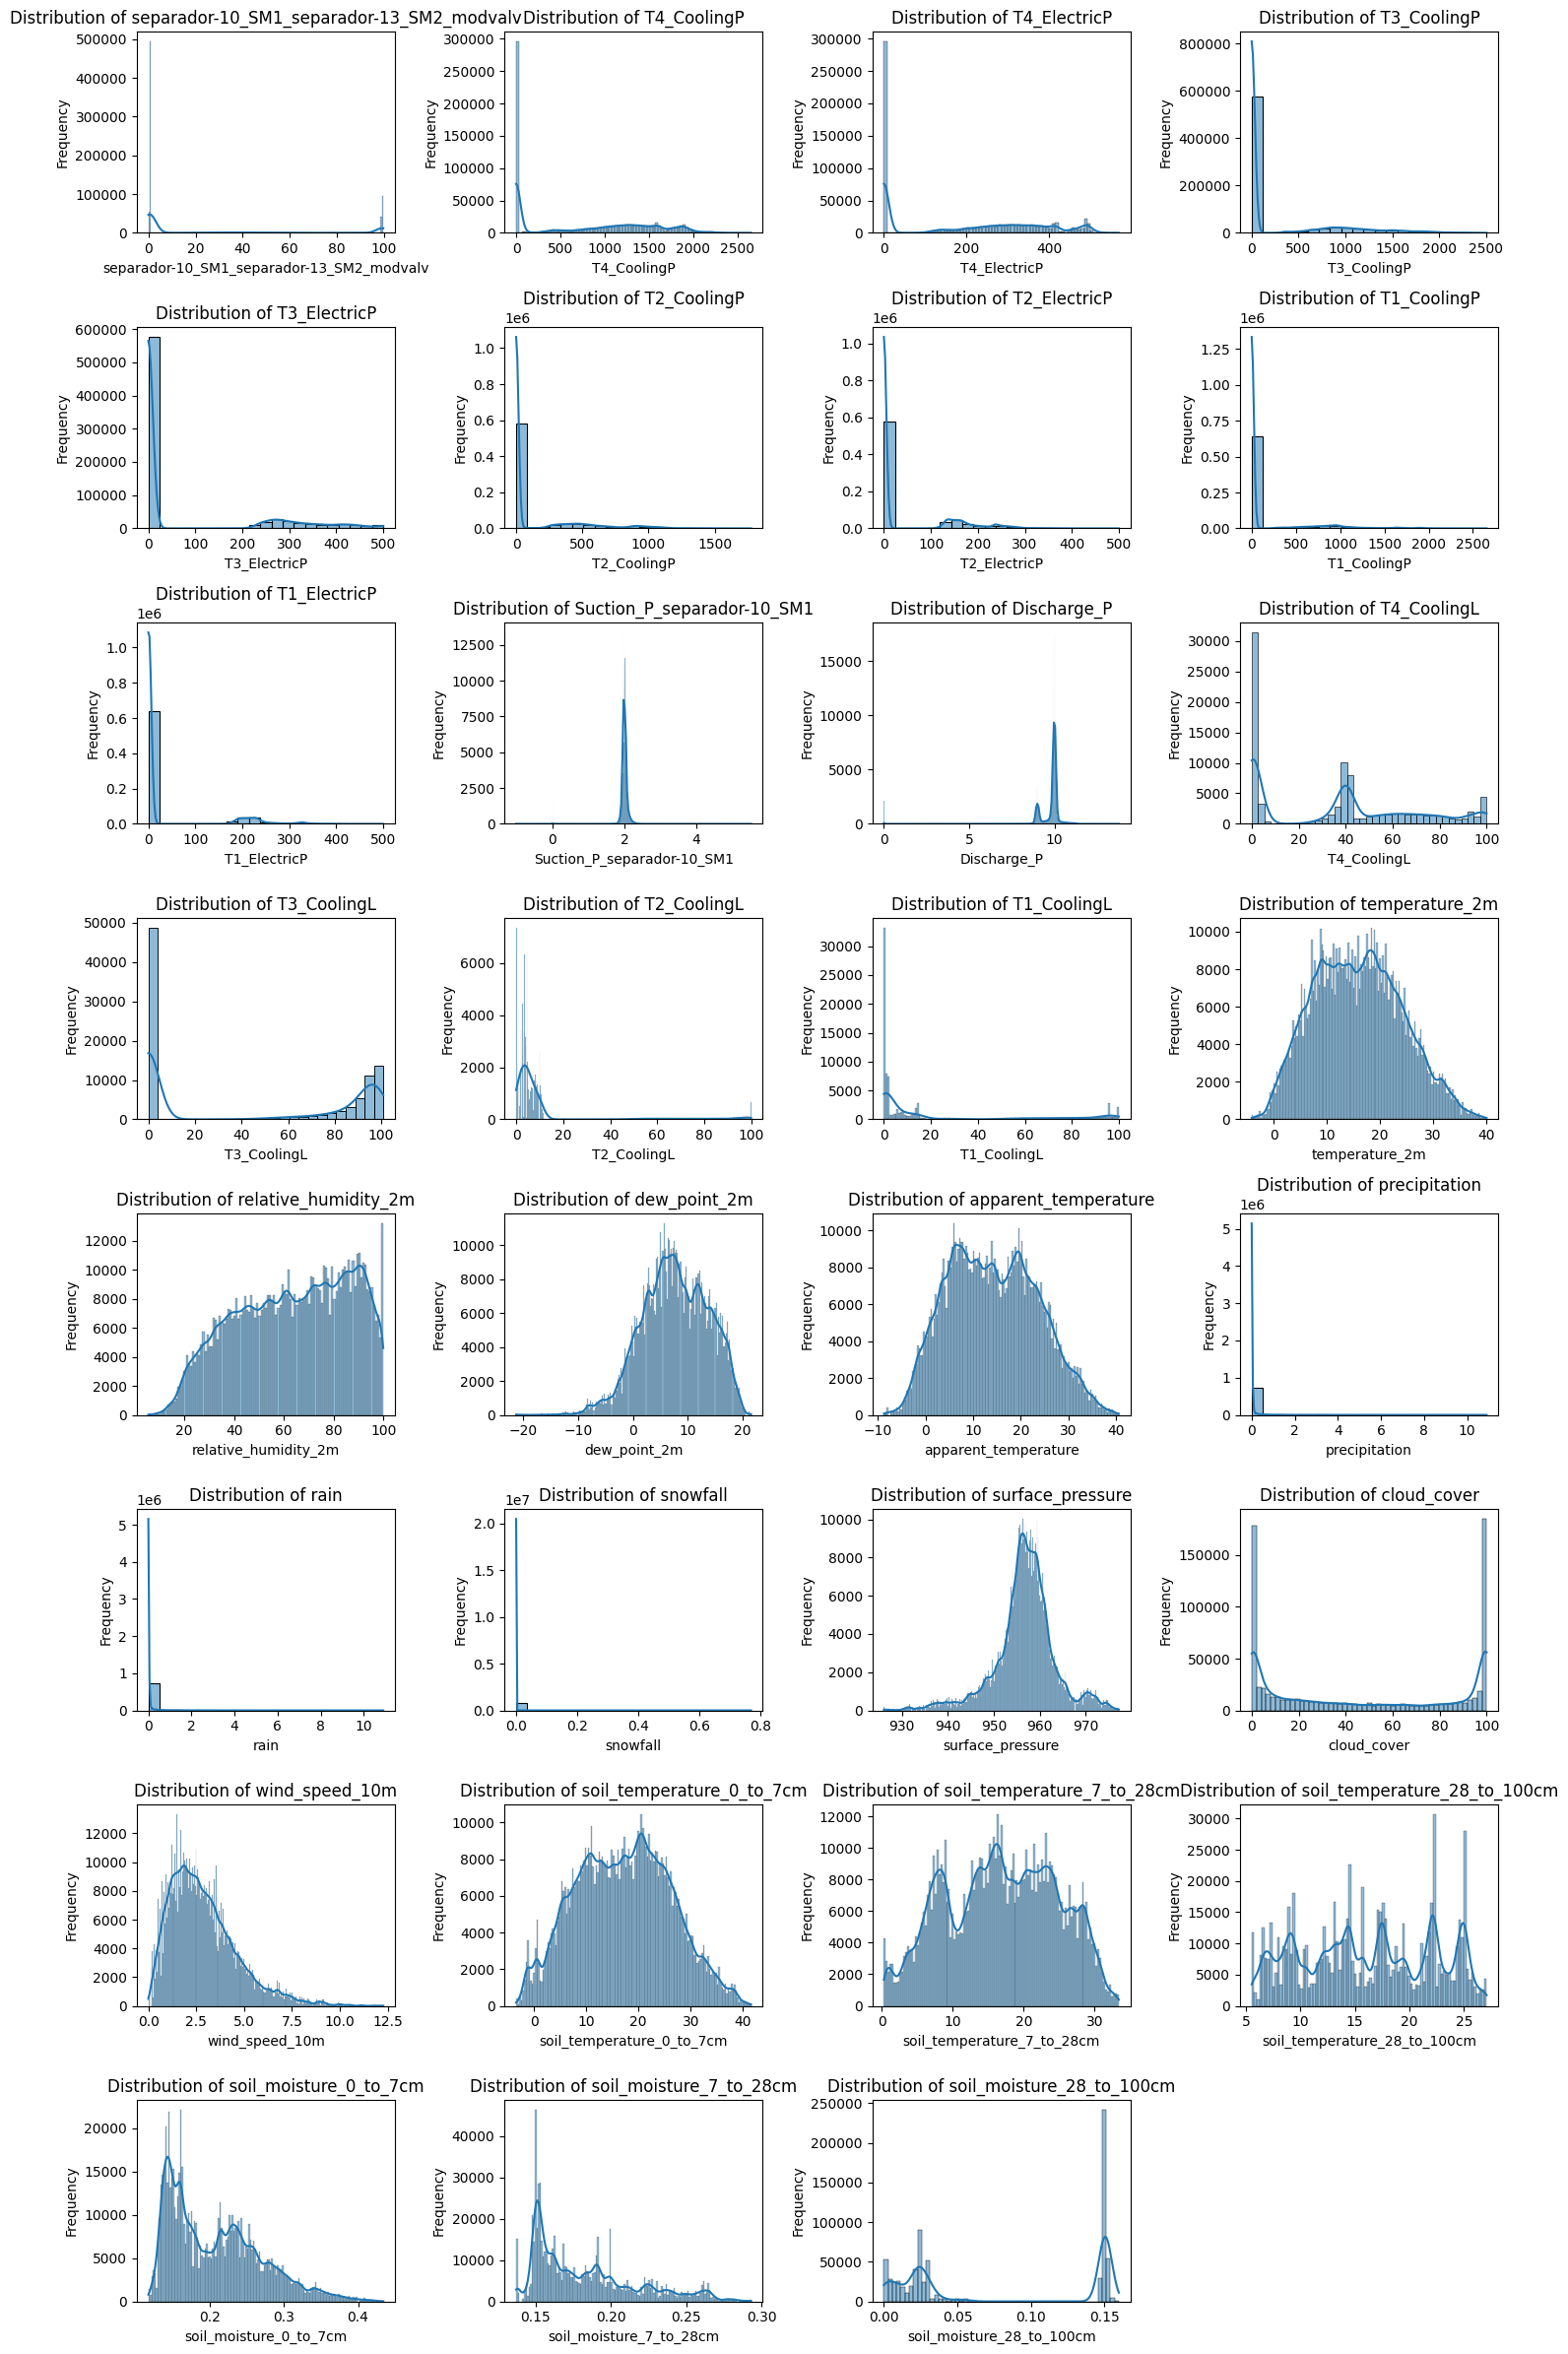

In [ ]:
# Plot histograms for each feature

# Exclude 'time' and 'utc' columns
columns_without_time = [col for col in data.columns if col not in ['temps', 'utc', 'date']]

# Determine the number of rows and columns for the subplots
n_cols = 4  # Number of columns in the subplot grid
n_rows = (len(columns_without_time) + n_cols - 1) // n_cols  # Calculate the number of rows needed

# Create subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 3))

# Flatten axes array for easy iteration
axes = axes.flatten()

# Plot histograms
for i, col in enumerate(columns_without_time):
    sns.histplot(data[col], kde=True, ax=axes[i])
    axes[i].set_title(f'Distribution of {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequency')

# Remove any empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


In [ ]:
# Define the target columns
target_columns = ['T1_ElectricP', 'T2_ElectricP', 'T3_ElectricP', 'T4_ElectricP']

# Identify all other columns in the DataFrame that are not targets or non-numerical
variables = [col for col in data.select_dtypes(include=['number']).columns if col not in target_columns]


# Calculate skewness and kurtosis
skewness = data[variables].apply(lambda x: skew(x.dropna()))
kurt = data[variables].apply(lambda x: kurtosis(x.dropna()))

# Create a DataFrame to display the results
distribution_stats = pd.DataFrame({
    'Skewness': skewness,
    'Kurtosis': kurt
})

# Display the results
distribution_stats


,Skewness,Kurtosis
separador-10_SM1_separador-13_SM2_modvalv,1.409031,0.126232
T4_CoolingP,0.191779,-1.474275
T3_CoolingP,1.861345,2.315405
T2_CoolingP,2.165189,3.952943
T1_CoolingP,2.940199,8.697562
Suction_P_separador-10_SM1,-4.508502,167.299523
Discharge_P,-8.910994,123.276975
T4_CoolingL,0.366764,-1.091101
T3_CoolingL,0.224629,-1.884764
T2_CoolingL,3.271100,9.494754


# Correlation and Feature Dependency Analysis

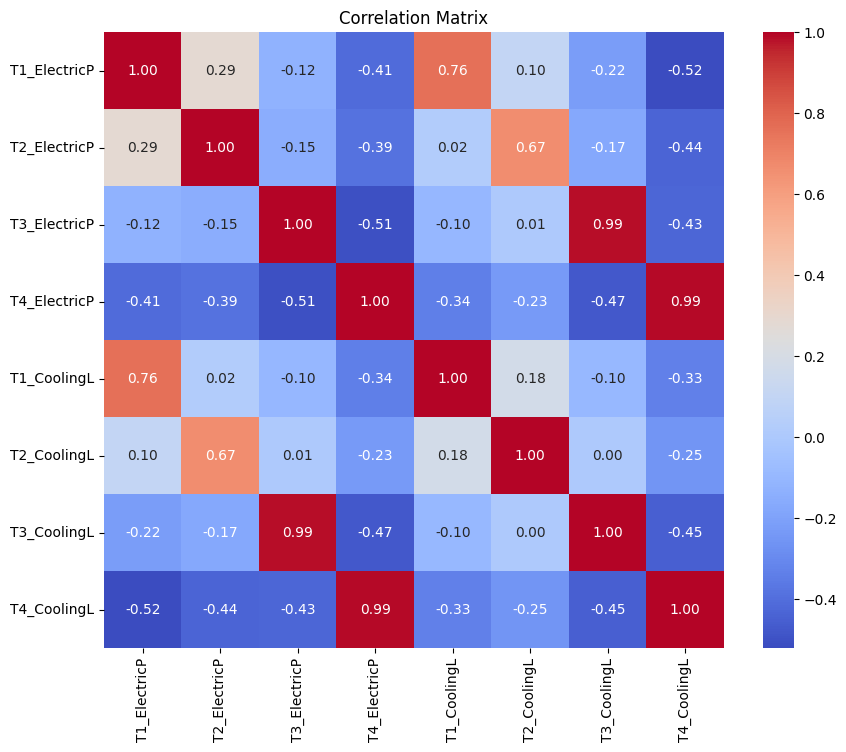

In [ ]:
# Compute correlation matrix for selected variables
correlation_matrix = data[['T1_ElectricP', 'T2_ElectricP', 'T3_ElectricP', 'T4_ElectricP',
                         'T1_CoolingL', 'T2_CoolingL', 'T3_CoolingL', 'T4_CoolingL']].corr()


# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()


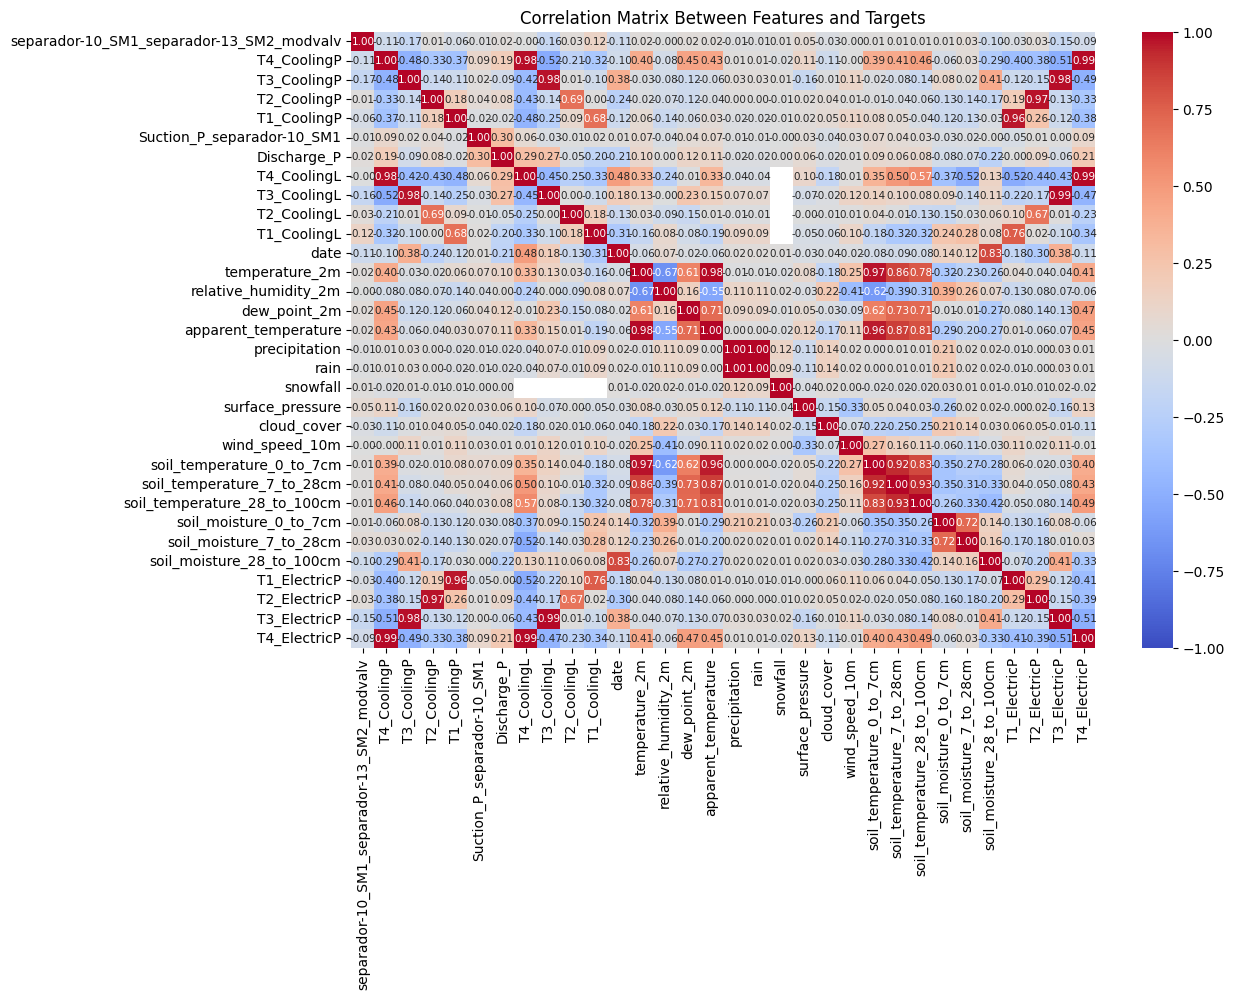

In [ ]:
# Features and targets
targets = ['T1_ElectricP', 'T2_ElectricP', 'T3_ElectricP', 'T4_ElectricP']

# List of columns to exclude
exclude_columns = ['T1_ElectricP', 'T2_ElectricP', 'T3_ElectricP', 'T4_ElectricP', 'temps', 'utc']

# Create features list by excluding certain columns
features = [col for col in data.columns if col not in exclude_columns]

# 1. Correlation between features and targets
correlation_matrix = data[features + targets].corr()

# Visualise Correlation Matrix
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", vmin=-1, vmax=1, annot_kws={"fontsize":7.5}, fmt=".2f")
plt.title("Correlation Matrix Between Features and Targets")
plt.show()

# Data Cleaning for analysis

In [ ]:
# Delete rows where any of the target columns have NaN values
data = data.dropna(subset=['T1_ElectricP', 'T2_ElectricP', 'T3_ElectricP', 'T4_ElectricP'])

In [ ]:
# List of columns to fill NaN values
columns_to_fill = ['T4_CoolingL', 'T3_CoolingL', 'T2_CoolingL', 'T1_CoolingL', 'separador-10_SM1_separador-13_SM2_modvalv', 'Suction_P_separador-10_SM1', 'Discharge_P']

# Fill NaN values with 0 using .loc to avoid the SettingWithCopyWarning
data.loc[:, columns_to_fill] = data.loc[:, columns_to_fill].fillna(0)

In [ ]:
data.isnull().sum()

,0
temps,0
separador-10_SM1_separador-13_SM2_modvalv,0
T4_CoolingP,0
T4_ElectricP,0
T3_CoolingP,0
T3_ElectricP,0
T2_CoolingP,0
T2_ElectricP,0
T1_CoolingP,0
T1_ElectricP,0


In [ ]:
# Drop duplicates by keeping the first occurrence of each index
data = data[~data.index.duplicated(keep='first')]

# Identify the duplicated index values
duplicated_indices = data.index[data.index.duplicated(keep=False)]

# Filter the DataFrame to show only the rows with duplicate indices
duplicates_df = data.loc[duplicated_indices]

# Check there are no duplicates left
duplicates_df

,temps,separador-10_SM1_separador-13_SM2_modvalv,T4_CoolingP,T4_ElectricP,T3_CoolingP,T3_ElectricP,T2_CoolingP,T2_ElectricP,T1_CoolingP,T1_ElectricP,Suction_P_separador-10_SM1,Discharge_P,utc,T4_CoolingL,T3_CoolingL,T2_CoolingL,T1_CoolingL,date,temperature_2m,relative_humidity_2m,dew_point_2m,apparent_temperature,precipitation,rain,snowfall,surface_pressure,cloud_cover,wind_speed_10m,soil_temperature_0_to_7cm,soil_temperature_7_to_28cm,soil_temperature_28_to_100cm,soil_moisture_0_to_7cm,soil_moisture_7_to_28cm,soil_moisture_28_to_100cm


# Time-Series Analysis

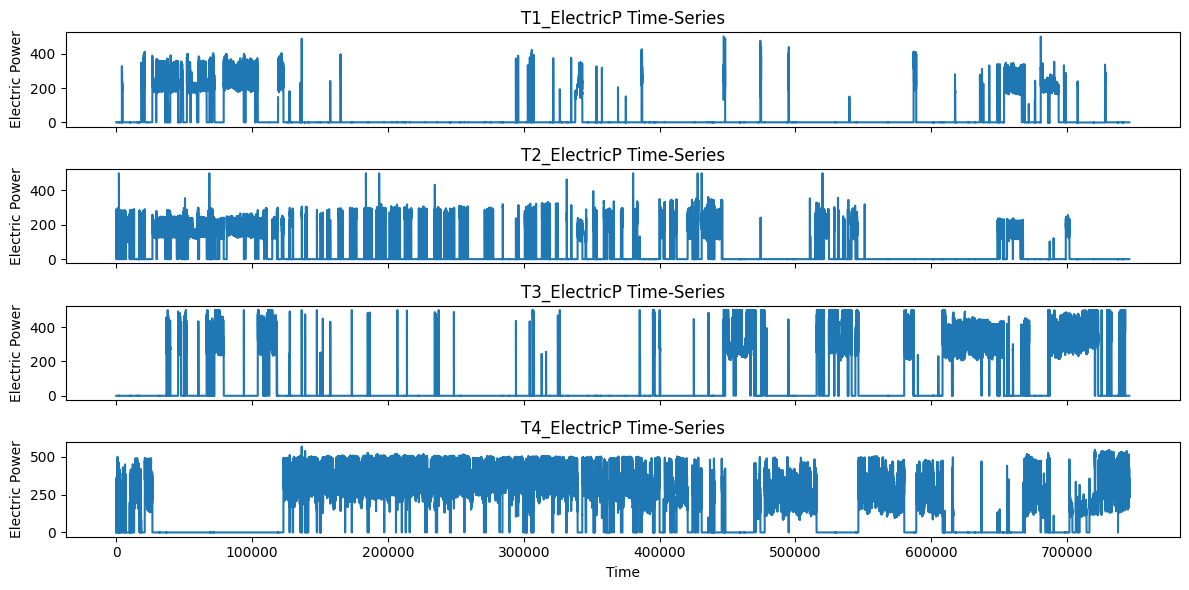

In [ ]:

fig, axes = plt.subplots(4, 1, figsize=(12, 6), sharex=True)

compressors = ['T1_ElectricP', 'T2_ElectricP', 'T3_ElectricP', 'T4_ElectricP']

for i, compressor in enumerate(compressors):
  axes[i].plot(data.index, data[compressor], label=compressor)
  axes[i].set_title(f'{compressor} Time-Series')
  axes[i].set_ylabel('Electric Power')
  axes[-1].set_xlabel('Time')

plt.tight_layout()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

def decompose_time_series(df, model='additive', period=1):
    """
    Decomposes the time series of each compressor into trend, seasonal, and residual components,
    and combines all components into subplots for each compressor.

    Parameters:
    - df: DataFrame containing the data.
    - model: Type of decomposition ('additive' or 'multiplicative').
    - period: The number of observations per cycle.
    """
    compressors = ['T1_ElectricP', 'T2_ElectricP', 'T3_ElectricP', 'T4_ElectricP']

    for compressor in compressors:
        decomposition = seasonal_decompose(df[compressor], model=model, period=period)

        # Create subplots
        fig, axes = plt.subplots(4, 1, figsize=(10, 8), sharex=True)
        fig.suptitle(f'Time Series Decomposition for {compressor}', fontsize=16)

        # Plot Original
        axes[0].plot(df[compressor], linestyle='-', label='Original')
        axes[0].set_title('Original')
        axes[0].legend()

        # Plot Trend
        axes[1].plot(decomposition.trend, linestyle='-', label='Trend')
        axes[1].set_title('Trend')
        axes[1].legend()

        # Plot Seasonal
        axes[2].plot(decomposition.seasonal, linestyle='-', label='Seasonal')
        axes[2].set_title('Seasonal')
        axes[2].legend()

        # Plot Residual
        axes[3].plot(decomposition.resid, linestyle='-', label='Residual')
        axes[3].set_title('Residual')
        axes[3].legend()

        # Adjust layout
        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.show()


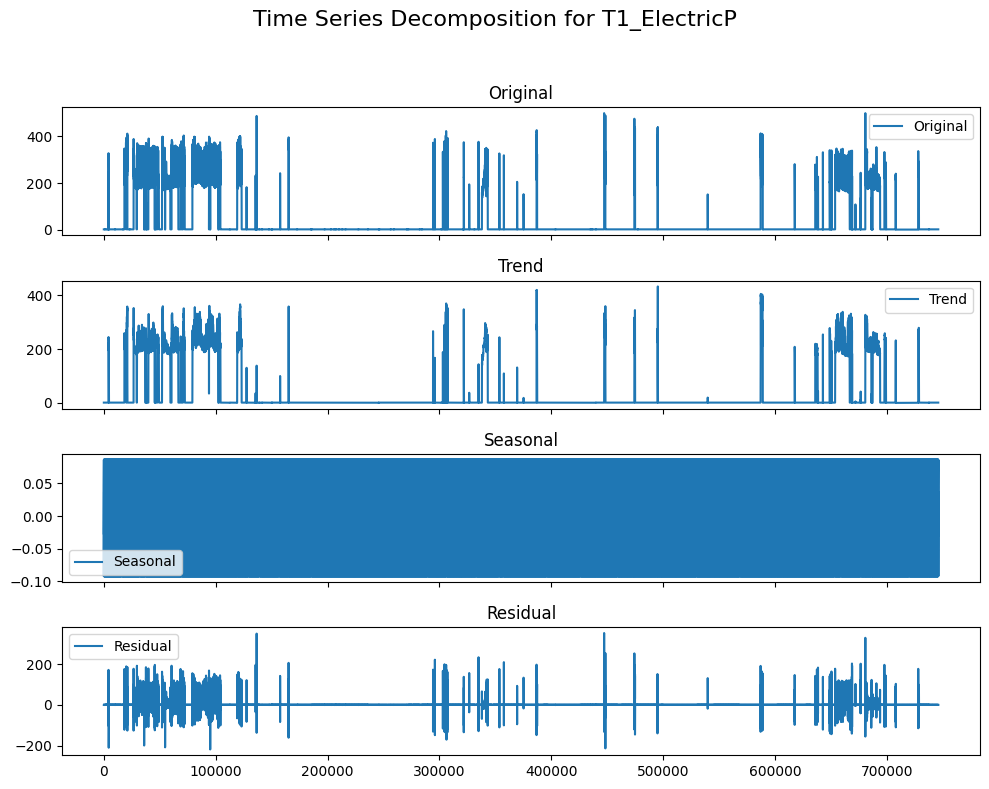

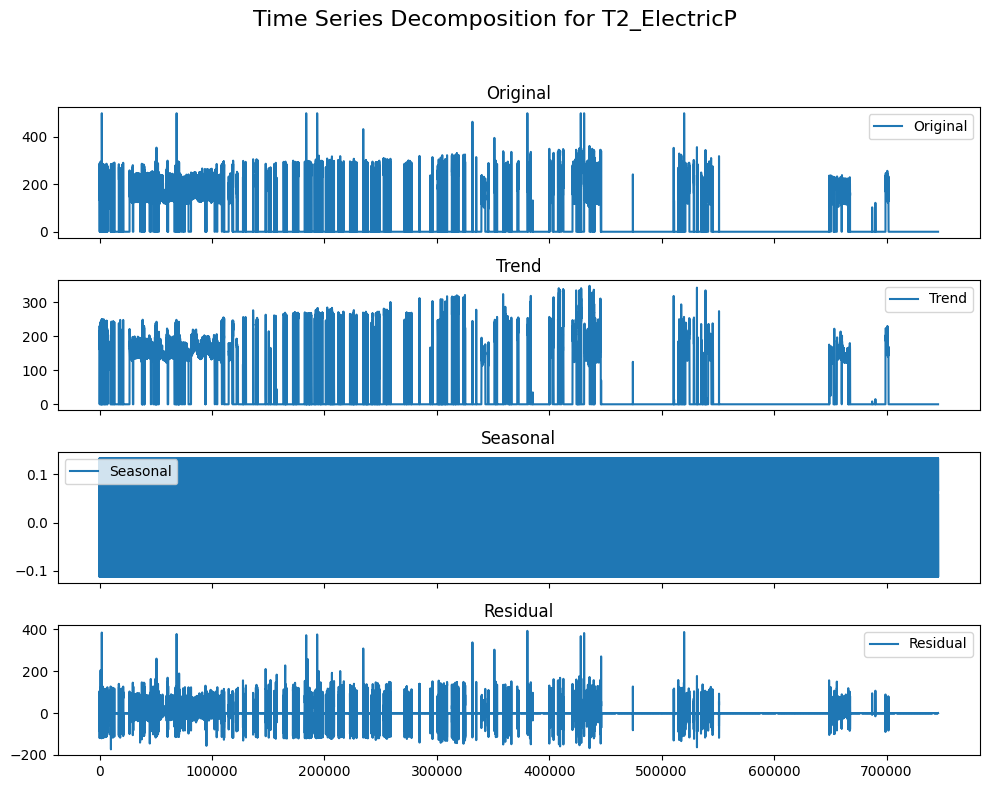

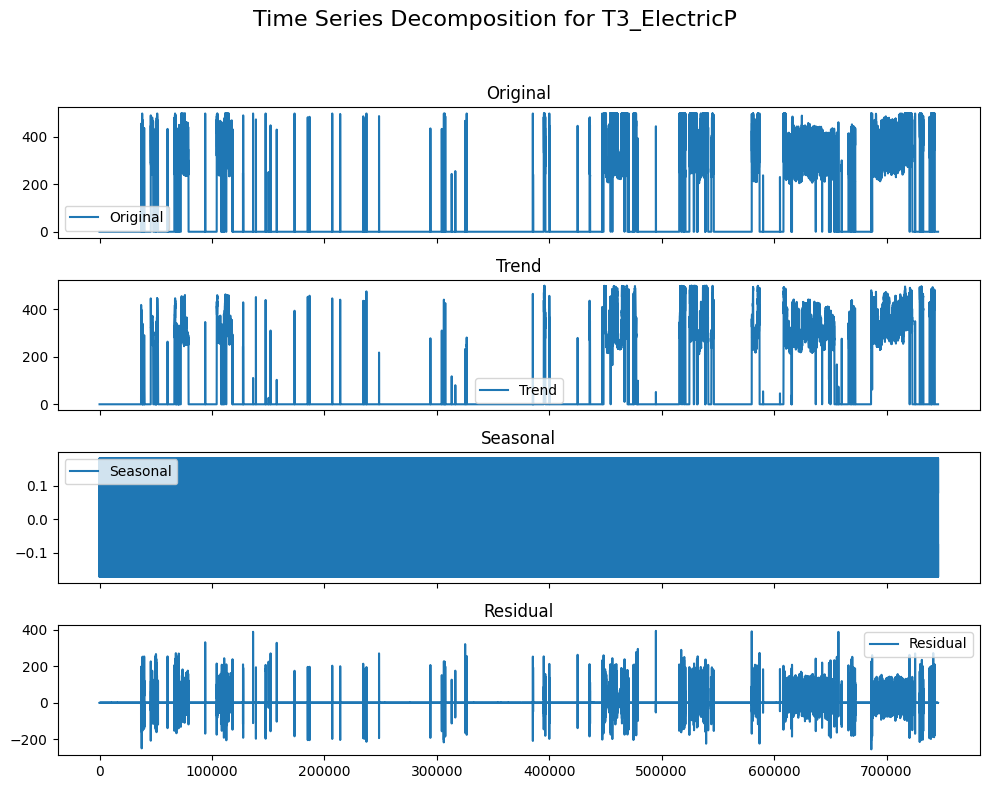

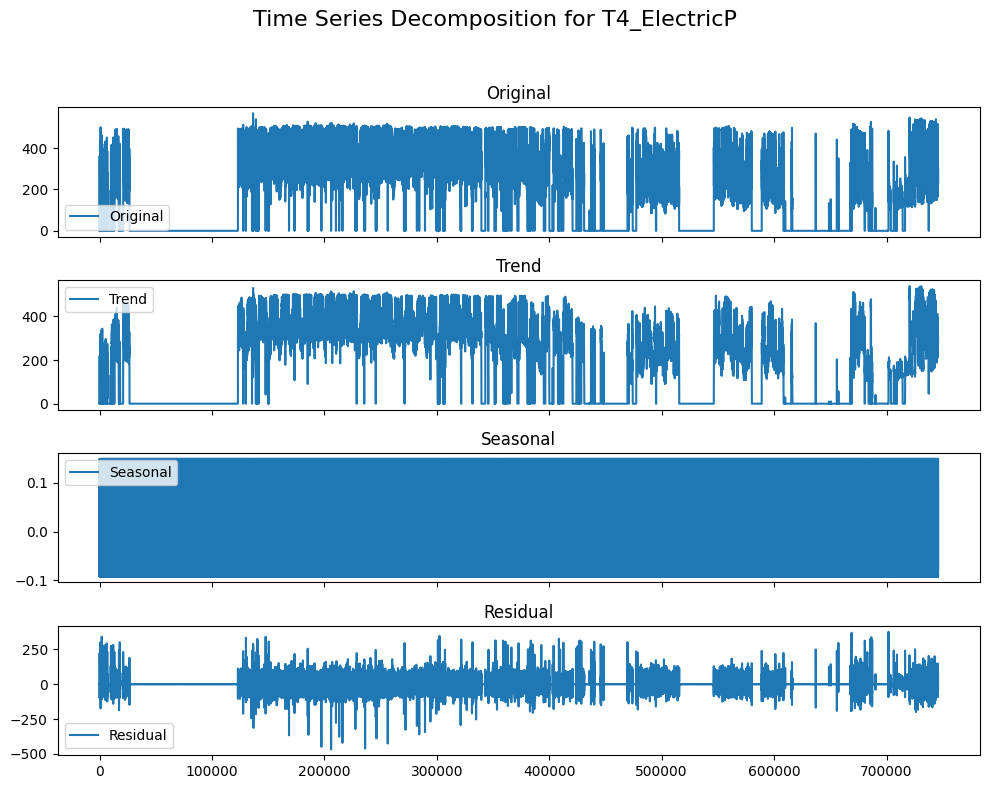

In [ ]:
decompose_time_series(data, model='additive', period=24)

## Autocorrelation

In [ ]:
def plot_autocorrelation(df, max_lag=5000):
    """
    Plots the autocorrelation for each target variable with limited lags.

    Parameters:
    - df: DataFrame containing the data.
    - max_lag: Maximum number of lags to calculate.
    """
    compressors = ['T1_ElectricP', 'T2_ElectricP', 'T3_ElectricP', 'T4_ElectricP']
    fig, axes = plt.subplots(2, 2, figsize=(20, 8))

    for i, compressor in enumerate(compressors):
        ax = axes[i // 2, i % 2]
        plot_acf(df[compressor], lags=max_lag, ax=ax)  # Limit the number of lags
        ax.set_title(f'Autocorrelation for {compressor}')

    plt.tight_layout()
    plt.show()

# Call the function with limited lags
plot_autocorrelation(data, max_lag=1000)


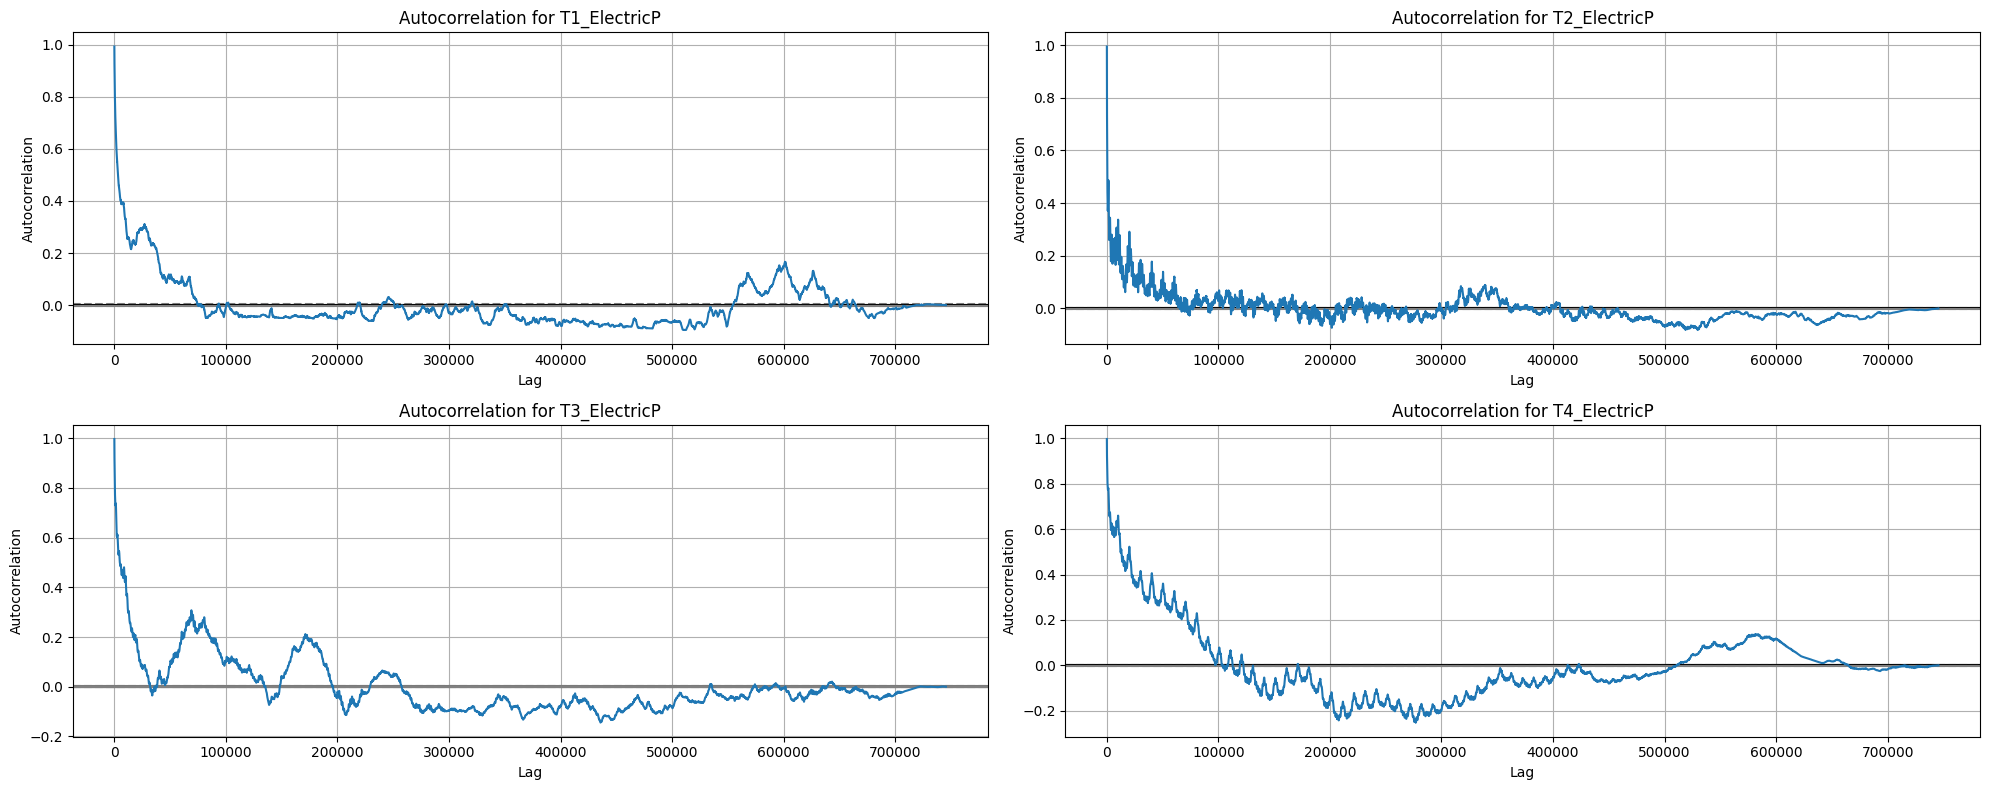

In [ ]:
plot_autocorrelation(data)

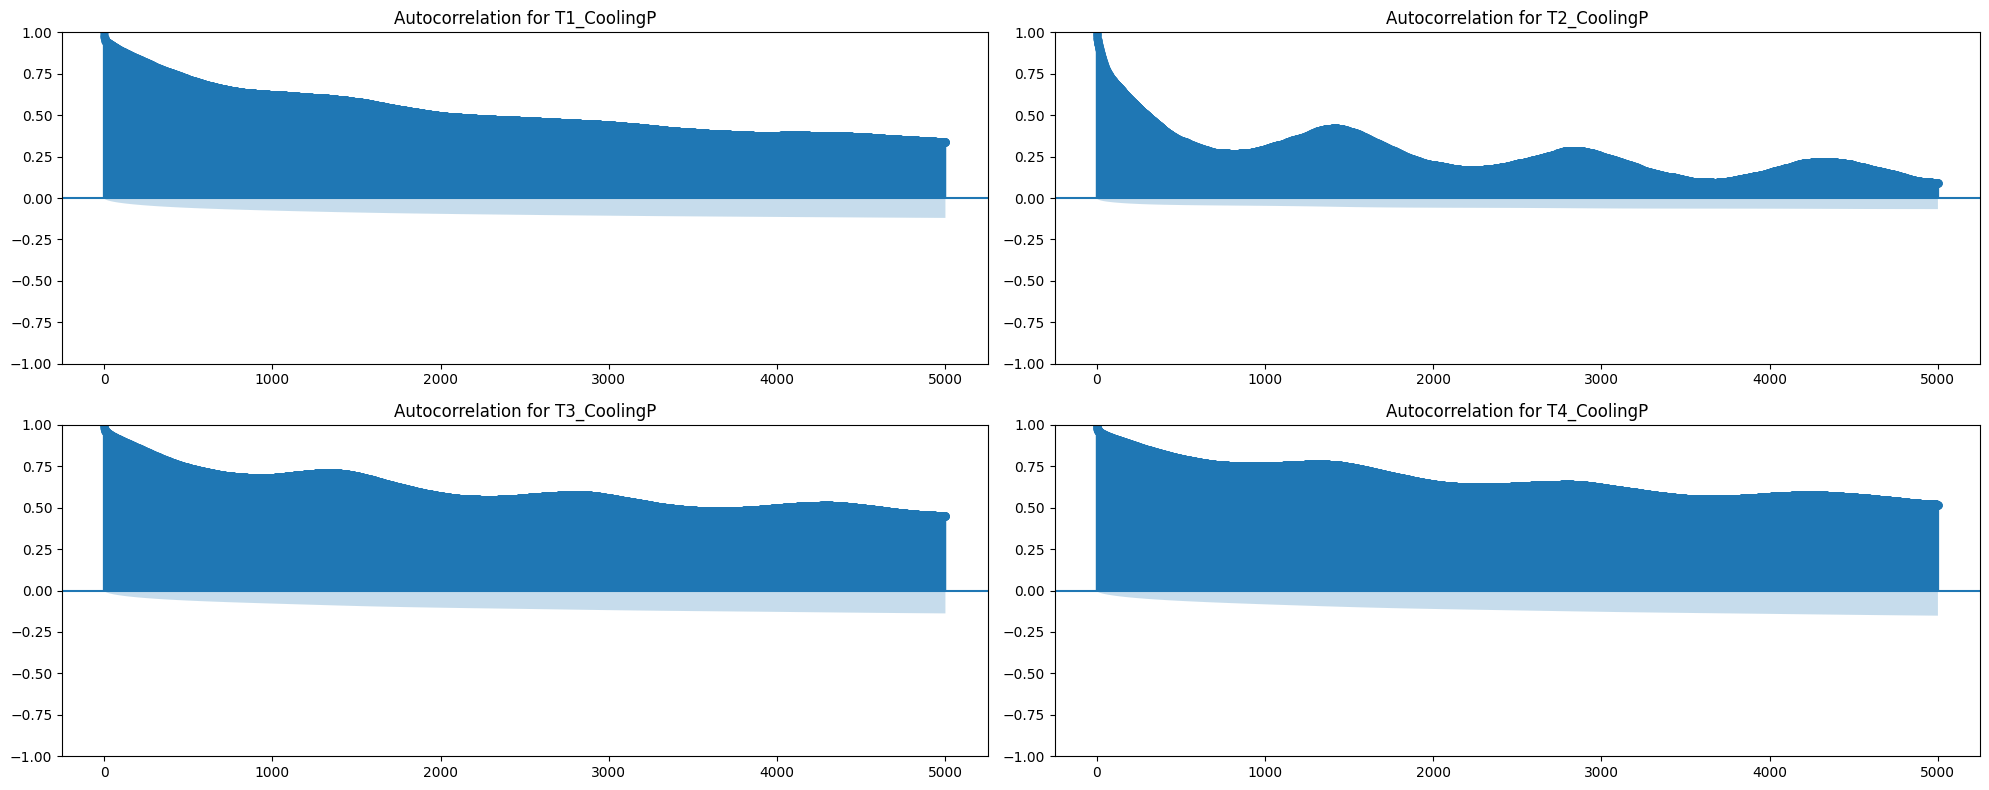

In [ ]:
def plot_autocorrelation(df, max_lag=5000):
    """
    Plots the autocorrelation for each target variable with limited lags.

    Parameters:
    - df: DataFrame containing the data.
    - max_lag: Maximum number of lags to calculate.
    """
    compressors = ['T1_CoolingP', 'T2_CoolingP', 'T3_CoolingP', 'T4_CoolingP']
    fig, axes = plt.subplots(2, 2, figsize=(20, 8))

    for i, compressor in enumerate(compressors):
        ax = axes[i // 2, i % 2]
        plot_acf(df[compressor], lags=max_lag, ax=ax)  # Limit the number of lags
        ax.set_title(f'Autocorrelation for {compressor}')

    plt.tight_layout()
    plt.show()


plot_autocorrelation(data)


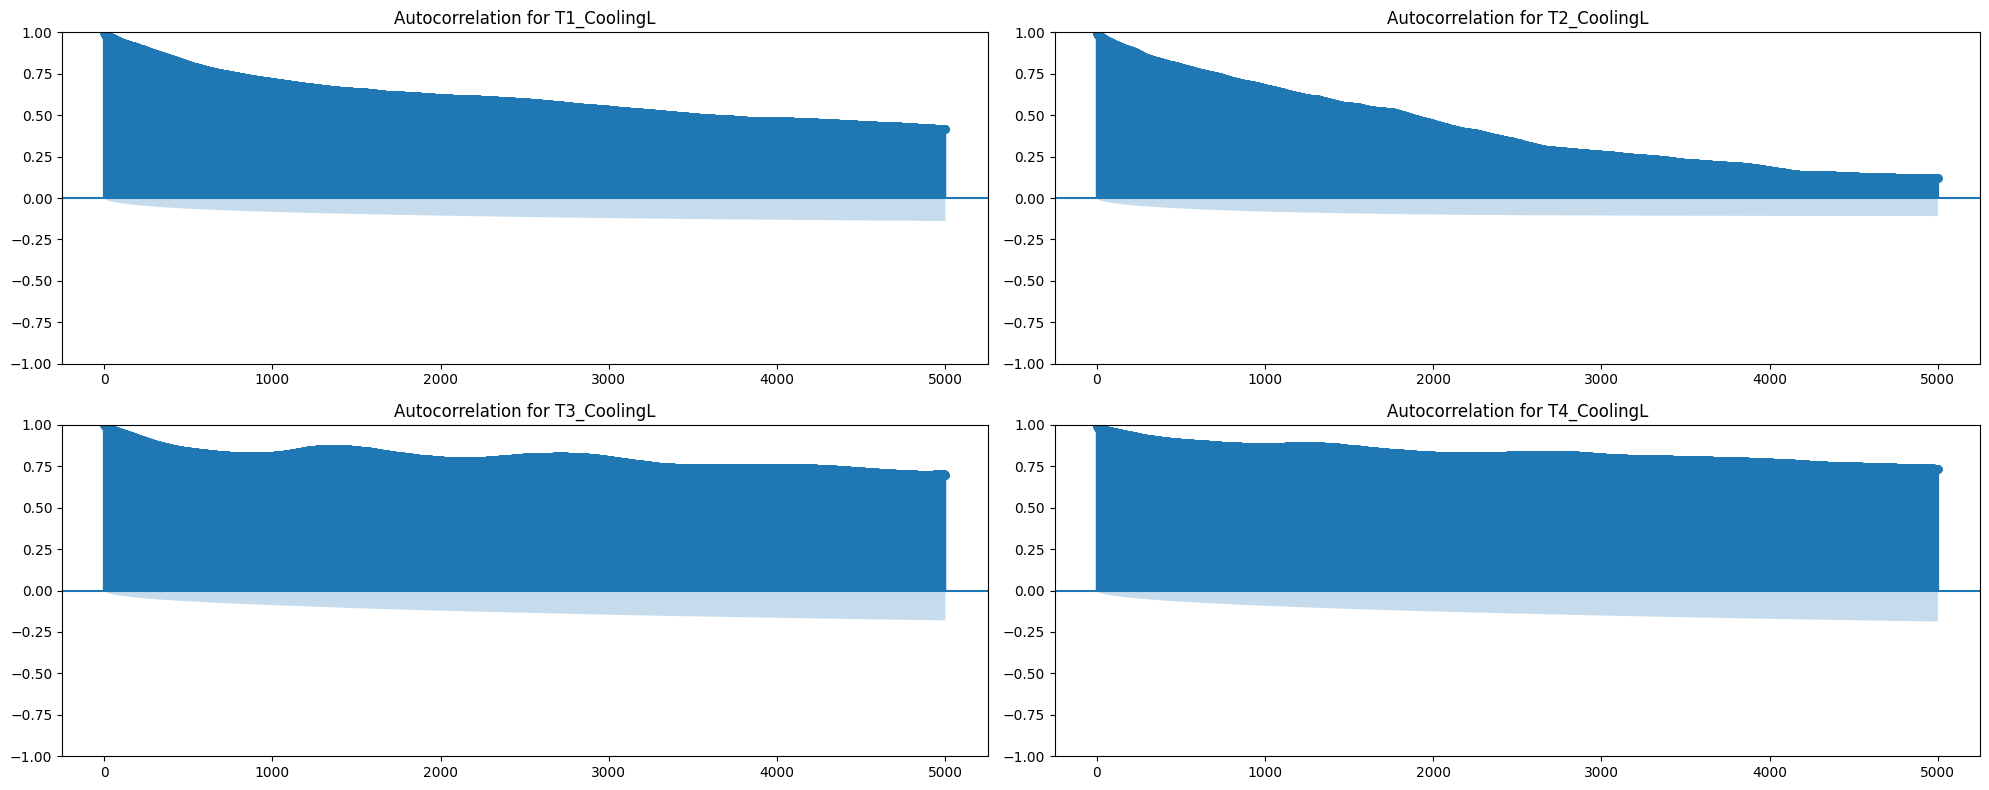

In [ ]:
def plot_autocorrelation(df, max_lag=5000):
    """
    Plots the autocorrelation for each target variable with limited lags.

    Parameters:
    - df: DataFrame containing the data.
    - max_lag: Maximum number of lags to calculate.
    """
    compressors = ['T1_CoolingL', 'T2_CoolingL', 'T3_CoolingL', 'T4_CoolingL']
    fig, axes = plt.subplots(2, 2, figsize=(20, 8))

    for i, compressor in enumerate(compressors):
        ax = axes[i // 2, i % 2]
        plot_acf(df[compressor], lags=max_lag, ax=ax)  # Limit the number of lags
        ax.set_title(f'Autocorrelation for {compressor}')

    plt.tight_layout()
    plt.show()


plot_autocorrelation(data)
